In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [11]:
train_data = pd.read_csv(RAW_PATH / 'train.csv', parse_dates=['date'])
train_data = train_data.set_index('date')

In [12]:
train_data.head()

,nextDayPlayerEngagement,games,rosters,playerBoxScores,teamBoxScores,transactions,standings,awards,events,playerTwitterFollowers,teamTwitterFollowers
date,,,,,,,,,,,
2018-01-01,"[{""engagementMetricsDate"":""2018-01-02"",""player...",NaN,"[{""playerId"":400121,""gameDate"":""2018-01-01"",""t...",NaN,NaN,"[{""transactionId"":340732,""playerId"":547348,""pl...",NaN,NaN,NaN,"[{""date"":""2018-01-01"",""playerId"":545361,""playe...","[{""date"":""2018-01-01"",""teamId"":147,""teamName"":..."
2018-01-02,"[{""engagementMetricsDate"":""2018-01-03"",""player...",NaN,"[{""playerId"":134181,""gameDate"":""2018-01-02"",""t...",NaN,NaN,"[{""transactionId"":339458,""playerId"":621173,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-03,"[{""engagementMetricsDate"":""2018-01-04"",""player...",NaN,"[{""playerId"":425492,""gameDate"":""2018-01-03"",""t...",NaN,NaN,"[{""transactionId"":347527,""playerId"":572389,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-04,"[{""engagementMetricsDate"":""2018-01-05"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-04"",""t...",NaN,NaN,"[{""transactionId"":339549,""playerId"":545343,""pl...",NaN,NaN,NaN,NaN,NaN
2018-01-05,"[{""engagementMetricsDate"":""2018-01-06"",""player...",NaN,"[{""playerId"":282332,""gameDate"":""2018-01-05"",""t...",NaN,NaN,"[{""transactionId"":341195,""playerId"":628336,""pl...",NaN,NaN,NaN,NaN,NaN


### time and player data 

In [13]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [14]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [15]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [16]:
from data.ingest_data import ingest_target, ingest_features
from data.util import filter_by_date, filter_by_id

In [17]:
%time target = ingest_target(train_data)

preprocessing target
CPU times: user 14.8 s, sys: 231 ms, total: 15.1 s
Wall time: 15.1 s


In [18]:
target.head()

,playerId,target1,target2,target3,target4,date,target_avg
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389


In [19]:
df = target.copy()

In [20]:
df = filter_by_id(df, player_in_test)

In [21]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [22]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [23]:
df = filter_by_id(df, [660271])#@#playerList['playerId'].head(10))

In [24]:
df.playerId.nunique()

1

In [25]:
# player stats

In [26]:
train_data.columns

Index(['nextDayPlayerEngagement', 'games', 'rosters', 'playerBoxScores',
       'teamBoxScores', 'transactions', 'standings', 'awards', 'events',
       'playerTwitterFollowers', 'teamTwitterFollowers'],
      dtype='object')

In [27]:
df = ingest_features(df, train_data)

In [28]:
# del train_data

### preprocessing 

In [29]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    df.loc[:, features] = ffilled_df
    return df

In [30]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df['rostersTime'] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float32)
    return df

In [31]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [32]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [47]:
# transformer for joining data and create base features
fill_forward_tmf = FunctionTransformer(forward_fill, kw_args={'features':['numberOfFollowers',
                                                                        'teamFollowers',
                                                                        'status',
                                                                        'teamId', 'rosterDate']})
join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season_csv': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players_csv': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [48]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('fill_forward', fill_forward_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [49]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [50]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName', 'status', 'teamId', 'awardId']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [51]:
# target statistics

stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'],
                             windows=[90],
                             drop_index=True)
stats_lagger_tmf = LagGen(lags=[1, 45], drop_index=False)

# create mean and median stats after lagging the target 1 day
stats_lagger_tmf = Pipeline([('lags', stats_lagger_tmf),
                             ('stats', stats_gen_tmf),
                             ('fillnan', FunctionTransformer(fillna)),
                             ('normalize', PdScaleNorm())])

# last 11 days as features
lagger_tmf = Pipeline([('lags', LagGen(lags=[1])),
                       ('fillnan', FunctionTransformer(fillna)),
                       ('normalize', PdScaleNorm())])


target_stats_tmf = PdColumnTransformer([
    ('lags_stats', stats_lagger_tmf, pp_cols),
    ('lags', lagger_tmf, pp_cols)
                                  ])

In [52]:
# continuous preprocessing

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [53]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', target_stats_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf)
                                  ])

In [54]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [55]:
from data.split import *

In [56]:
sp = SplitData("2021-03-01", test_days=61)

In [57]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [58]:
%%time
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 134 ms


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f823558e3a0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season_csv': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f823558e1f0>,
                                                      kw_args={'path_to_players_csv': PosixPath('data/r...
                                                   PdColumnTransformer(transformers=[('playerId',
                                                                                      Categorify(add_nan=True),
                                                     

In [59]:
%%time
features = pipeline.transform(df)

CPU times: user 111 ms, sys: 14 µs, total: 111 ms
Wall time: 109 ms


In [60]:
pd.options.display.max_rows = 100
features.T

,0,1,2,3,4,5,6,7,8,9,...,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215
target1__1lag__mean__90d,0.0,0.031748,0.031748,0.031748,0.031748,0.031748,0.031748,0.031748,0.031748,0.031748,...,0.645512,0.654405,0.654884,0.659681,0.679097,0.701998,0.726328,0.727868,0.733731,0.736083
target1__1lag__median__90d,0.0,0.075768,0.075768,0.075768,0.075768,0.075768,0.075768,0.075768,0.075768,0.075768,...,0.658651,0.667934,0.667934,0.698790,0.730364,0.764702,0.802683,0.802683,0.811897,0.811897
target1__1lag__std__90d,0.0,0.000000,0.027383,0.027383,0.027383,0.027383,0.027383,0.027383,0.027383,0.027383,...,0.725336,0.723299,0.723001,0.720906,0.725927,0.735112,0.745773,0.744770,0.742226,0.740760
target2__1lag__mean__90d,0.0,0.090634,0.074030,0.068659,0.068714,0.061621,0.061597,0.067723,0.075196,0.074522,...,0.426059,0.431762,0.433342,0.437359,0.445777,0.459344,0.473114,0.478084,0.483534,0.488426
target2__1lag__median__90d,0.0,0.087865,0.071768,0.056146,0.061461,0.056146,0.057872,0.059599,0.063188,0.066777,...,0.295224,0.307827,0.307827,0.328569,0.356302,0.367545,0.370346,0.371760,0.386274,0.405269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
year,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
primaryPositionName,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
status,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
teamId,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
time_dp_features = ['battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts',
       'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts',
       'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats',
       'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [62]:
all_features = features.columns

In [63]:
import re
def filter_by_pattern(features: List[str], pattern: str):
    return [f for f in features
            if re.search(pattern, f) is not None]

In [64]:
# re.search('^target(.*?)\d*lag$', 'target4__60lag__median__90d')

In [65]:
one_lag_features = filter_by_pattern(all_features, '^target(.*?)\d*lag$')

In [66]:
one_lag_features = filter_by_pattern(all_features, '^target(.*?)\d*lag$')

In [67]:
one_lag_moving_stats = filter_by_pattern(all_features,
                                         '^target\d__1lag(.*?)\d*d$')

In [68]:
one_lag_moving_stats

['target1__1lag__mean__90d',
 'target1__1lag__median__90d',
 'target1__1lag__std__90d',
 'target2__1lag__mean__90d',
 'target2__1lag__median__90d',
 'target2__1lag__std__90d',
 'target3__1lag__mean__90d',
 'target3__1lag__median__90d',
 'target3__1lag__std__90d',
 'target4__1lag__mean__90d',
 'target4__1lag__median__90d',
 'target4__1lag__std__90d']

In [69]:
real_data_moving_stats = filter_by_pattern(all_features,
                                         '^target\d__60lag(.*?)\d*d$')

In [70]:
real_data_moving_stats

[]

In [71]:
static_features = list(all_features.drop((one_lag_features +
                                         one_lag_moving_stats +
                                         real_data_moving_stats + 
                                         categories + time_dp_features)))

In [72]:
static_features

['target1__45lag__mean__90d',
 'target1__45lag__median__90d',
 'target1__45lag__std__90d',
 'target2__45lag__mean__90d',
 'target2__45lag__median__90d',
 'target2__45lag__std__90d',
 'target3__45lag__mean__90d',
 'target3__45lag__median__90d',
 'target3__45lag__std__90d',
 'target4__45lag__mean__90d',
 'target4__45lag__median__90d',
 'target4__45lag__std__90d',
 'numberOfFollowers',
 'teamFollowers',
 'weight',
 'height',
 'playerBMI',
 'playerAge',
 'playerTSinceDebut',
 'playerDebutAge',
 'rostersTime']

In [73]:
df[target_cols] = df[target_cols].astype(np.float32)

In [74]:
train_data = sp.filter(features, train_idx)
raw_train_df = sp.filter(df, train_idx)

In [75]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [76]:
train_data.shape, raw_valid_df.shape


((1155, 117), (61, 86))

In [77]:
valid_data.shape, raw_train_df.shape

((61, 117), (1155, 86))

In [78]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [79]:
from omegaconf import OmegaConf
hp = {'bptt': 7,
      'epochs': 10,
      'batch_size': 64,
      'max_emb_sz': 20,
      'hidden_dim': 10,
      'encoder_dim': 50,
      'emb_dropout': 0.05,
      'dropout': 0.05,
      'lr': 0.001,
      'wd': 0.}

real_data_config = {'hp': hp,
                    'seed': 2021,
         'static_features': static_features+real_data_moving_stats,
          'categories': categories,
          'time_features': time_dp_features,
          'target_cols': target_cols}
real_data_config = OmegaConf.create(real_data_config) 

In [80]:
from train.lstm import run_lstm

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [81]:
real_data_lstm_output = run_lstm(real_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 62    
1 | net          | LSTM           | 3.4 K 
2 | output_layer | Sequential     | 2.4 K 
------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.023     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [82]:
hp = {'bptt': 7,
      'epochs': 5,
      'batch_size': 512,
      'max_emb_sz': 20,
      'hidden_dim': 10,
      'encoder_dim': 50,
      'emb_dropout': 0.05,
      'dropout': 0.05,
      'lr': 0.001,
      'wd': 0.}

onelag_data_config = {'hp': hp,
                    'seed': 2021,
                     'static_features': static_features,
                      'categories': categories,
                      'time_features': time_dp_features + one_lag_features,
                      'target_cols': target_cols}
onelag_data_config = OmegaConf.create(onelag_data_config)

In [83]:
lag_data_lstm_output = run_lstm(onelag_data_config, train_data, valid_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 62    
1 | net          | LSTM           | 3.6 K 
2 | output_layer | Sequential     | 2.4 K 
------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [84]:
from train.core import predict_recursive, Ensemble
ensemble = Ensemble([real_data_lstm_output, lag_data_lstm_output],
                    pipeline)

In [85]:
%%time
raw_train_fr = raw_train_df[df.columns].copy()

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     ensemble,
                                                     n_days=90 + 60 + 10,
                                                     target_cols=target_cols)
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

     target1    target2    target3    target4       date  playerId
0  25.143921  35.720142  29.258732  30.293976 2021-03-01    660271
     target1    target2    target3    target4       date  playerId
0  25.221603  35.789444  29.306952  30.340416 2021-03-02    660271
     target1    target2    target3    target4       date  playerId
0  25.254955  35.807354  29.316864  30.357441 2021-03-03    660271
     target1    target2    target3   target4       date  playerId
0  25.272377  35.813271  29.315197  30.36953 2021-03-04    660271
     target1    target2   target3   target4       date  playerId
0  25.283699  35.812778  29.31179  30.37516 2021-03-05    660271
     target1    target2    target3    target4       date  playerId
0  25.292505  35.810745  29.308842  30.379633 2021-03-06    660271
     target1    target2    target3    target4       date  playerId
0  25.303074  35.813457  29.309158  30.379305 2021-03-07    660271
     target1    target2    target3    target4       date  playerId
0

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

In [86]:
from evaluate.metrics import compute_metrics

In [87]:
# /
prediction = (real_data_lstm_output.prediction + lag_data_lstm_output.prediction) / 2

# prediction = real_data_lstm_output.prediction

valid_test_prediction = pd.DataFrame(prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

valid_rc_prediction, test_rc_prediction = (recursive_prediction.loc[~is_test_pred, :],
                                           recursive_prediction.loc[is_test_pred, :])

In [88]:
compute_metrics(valid_prediction)

{'mae_mean': 24.007008,
 'mae_1': 25.662151,
 'mae_2': 25.661566,
 'mae_3': 28.22345,
 'mae_4': 16.480864}

In [89]:
compute_metrics(valid_rc_prediction)

{'mae_mean': 24.00074438798812,
 'mae_1': 25.66875659650372,
 'mae_2': 25.70197932950912,
 'mae_3': 28.145773710743075,
 'mae_4': 16.486467915196574}

In [90]:
{'mae_mean': 2.176556138740044,
 'mae_1': 1.5184514497094725,
 'mae_2': 3.6559109587827647,
 'mae_3': 1.5603365105655878,
 'mae_4': 1.9715256359023514}

{'mae_mean': 2.176556138740044,
 'mae_1': 1.5184514497094725,
 'mae_2': 3.6559109587827647,
 'mae_3': 1.5603365105655878,
 'mae_4': 1.9715256359023514}

In [91]:
compute_metrics(test_prediction)

{'mae_mean': 23.769333,
 'mae_1': 23.685354,
 'mae_2': 19.957369,
 'mae_3': 29.015898,
 'mae_4': 22.418713}

In [92]:
compute_metrics(test_rc_prediction)

{'mae_mean': 23.886378568162524,
 'mae_1': 24.156428679823875,
 'mae_2': 19.738820266723632,
 'mae_3': 29.401932634909947,
 'mae_4': 22.248332691192626}

{'mae_mean': 1.5404789536821677,
 'mae_1': 1.262642546937023,
 'mae_2': 2.262865827626326,
 'mae_3': 1.0018937801228949,
 'mae_4': 1.6345136600424273}

In [93]:
compute_metrics(valid_test_prediction)

{'mae_mean': 23.890121,
 'mae_1': 24.689957,
 'mae_2': 22.85622,
 'mae_3': 28.613182,
 'mae_4': 19.401121}

In [94]:
compute_metrics(recursive_prediction)

{'mae_mean': 23.94449890282799,
 'mae_1': 24.924988768628385,
 'mae_2': 22.769278151090028,
 'mae_3': 28.76355678820219,
 'mae_4': 19.320171903391355}

In [95]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [96]:
(valid_test_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,23.890121,24.689957,22.85622,28.613182,19.401121


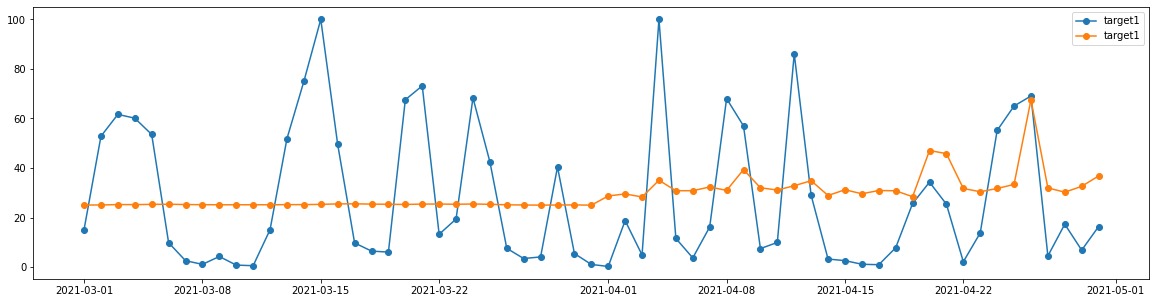

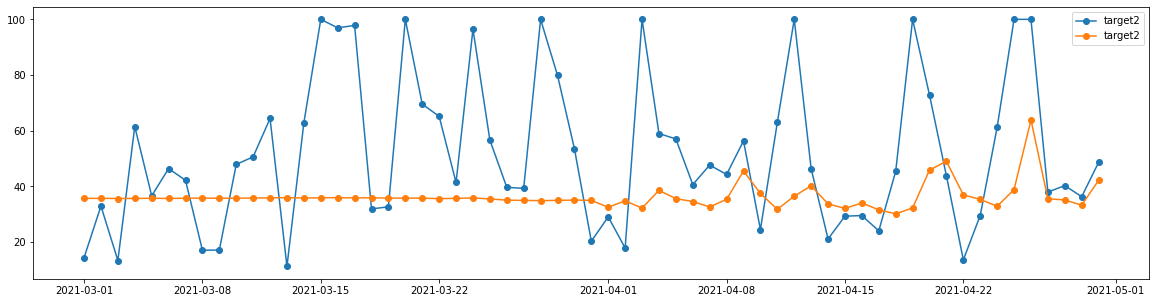

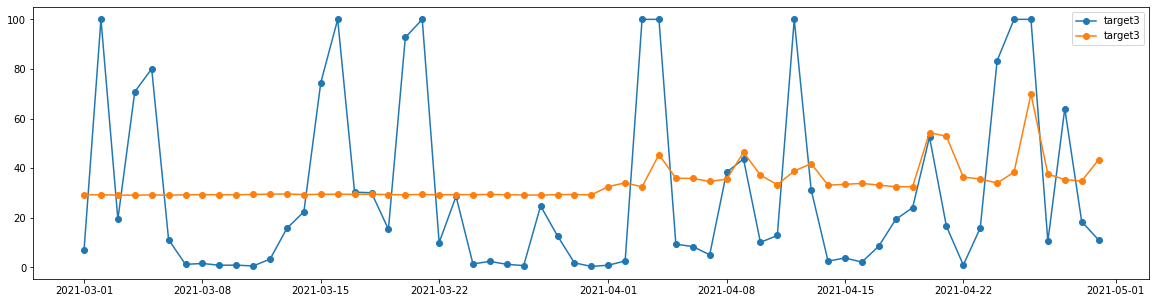

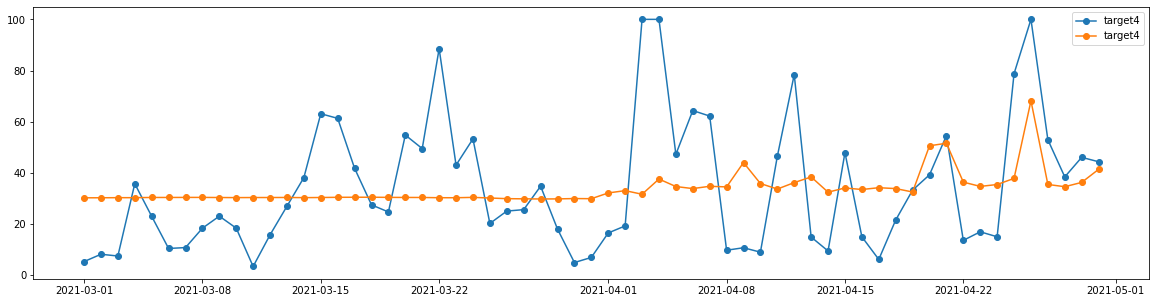

In [97]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

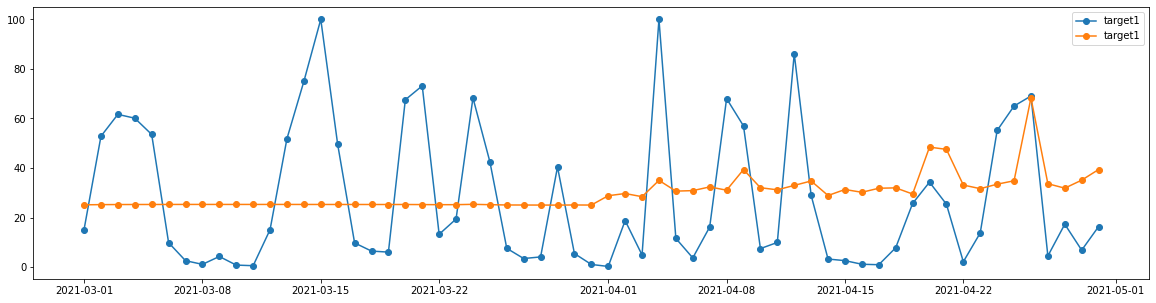

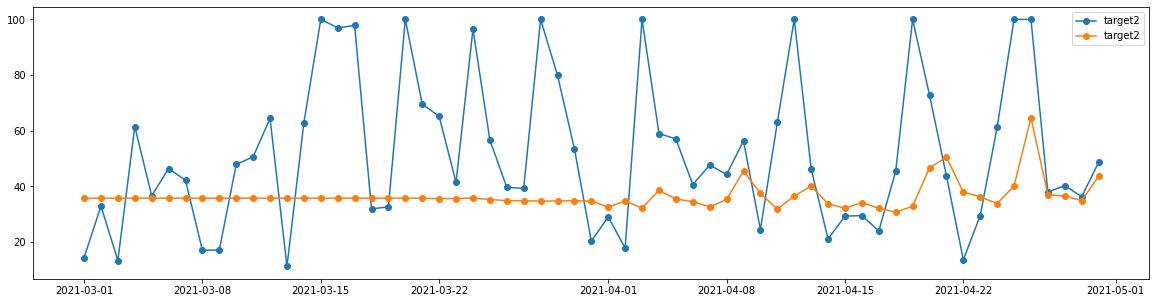

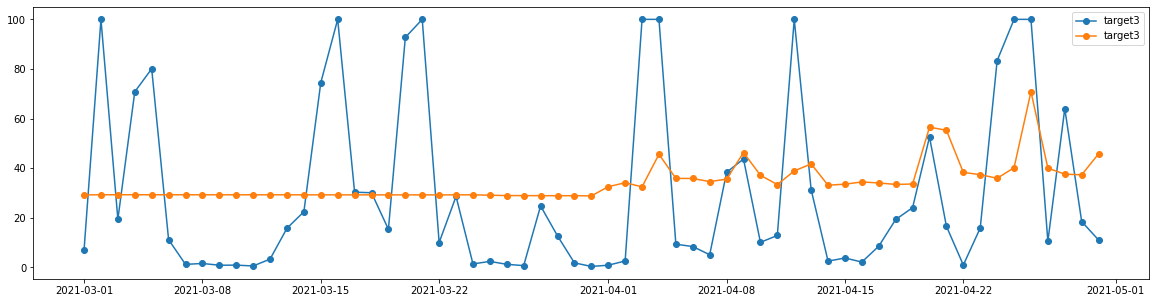

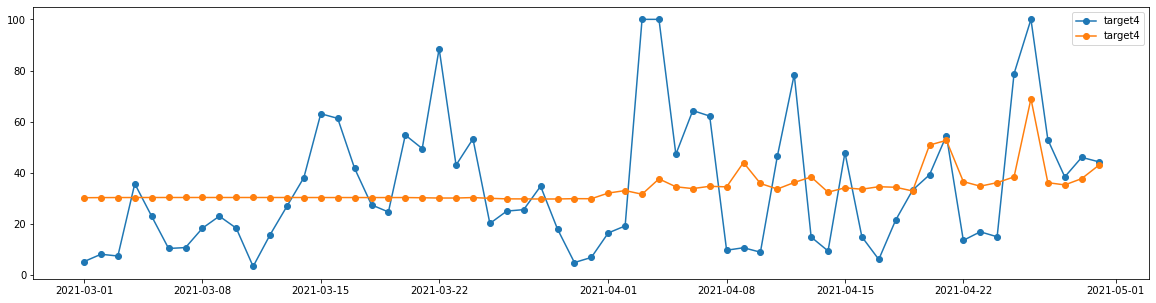

In [98]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)